In [9]:
# Celda 1: Instalación e importación de librerías necesarias
!pip install --quiet boto3

import pandas as pd
import numpy as np
import pickle
import boto3
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
from datetime import date

In [10]:
# Celda 2: Cargar credenciales y definir funciones de carga
def load_model(bucket, model_path):
    """
    Carga el modelo seleccionado desde S3
    """
    session = boto3.Session(
        aws_access_key_id=config['s3']['aws_access_key_id'],
        aws_secret_access_key=config['s3']['aws_secret_access_key'],
        aws_session_token=config['s3']['aws_session_token']
    )
    
    s3 = session.resource('s3')
    obj = s3.Object(bucket, model_path).get()['Body'].read()
    return pickle.loads(obj)

def load_test(bucket, test_path):
    """
    Carga el conjunto de datos de prueba desde S3
    """
    session = boto3.Session(
        aws_access_key_id=config['s3']['aws_access_key_id'],
        aws_secret_access_key=config['s3']['aws_secret_access_key'],
        aws_session_token=config['s3']['aws_session_token']
    )
    
    s3 = session.resource('s3')
    obj = s3.Object(bucket, test_path).get()['Body'].read()
    return pickle.loads(obj)

In [11]:
# Celda 3: Funciones de predicción y guardado
def get_predictions(model, data):
    """
    Genera predicciones en formato de probabilidad
    """
    X = data.iloc[:, :-1]  # Todas las columnas excepto la última
    return model.predict_proba(X)[:, 1]

def save_predictions(predictions, bucket, prediction_date):
    """
    Guarda las predicciones en S3
    """
    session = boto3.Session(
        aws_access_key_id=config['s3']['aws_access_key_id'],
        aws_secret_access_key=config['s3']['aws_secret_access_key'],
        aws_session_token=config['s3']['aws_session_token']
    )
    
    s3 = session.resource('s3')
    predictions_dict = {
        'predictions': predictions,
        'date': prediction_date
    }
    pickle_data = pickle.dumps(predictions_dict)
    s3.Object(bucket, 'results/predictions_score.pkl').put(Body=pickle_data)

In [14]:
# Celda 4: Funciones de métricas y visualización
def generate_roc(predictions, true_labels, bucket):
    """
    Genera y guarda la curva ROC
    """
    # Convert categorical labels to numeric
    numeric_labels = (true_labels == 'pass').astype(int)
    fpr, tpr, _ = roc_curve(numeric_labels, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    
    # Guardar la imagen
    plt.savefig('/tmp/roc.png')
    
    session = boto3.Session(
        aws_access_key_id=config['s3']['aws_access_key_id'],
        aws_secret_access_key=config['s3']['aws_secret_access_key'],
        aws_session_token=config['s3']['aws_session_token']
    )
    
    s3 = session.resource('s3')
    with open('/tmp/roc.png', 'rb') as f:
        s3.Object(bucket, 'results/roc.png').put(Body=f.read())

def generate_metrics(predictions, true_labels, bucket):
    """
    Genera y guarda métricas de desempeño
    """
    # Convert categorical labels to numeric
    numeric_labels = (true_labels == 'pass').astype(int)
    precision, recall, thresholds = precision_recall_curve(numeric_labels, predictions, pos_label=1)
    
    metrics_list = []
    for threshold in thresholds:
        pred_labels = (predictions >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(numeric_labels, pred_labels).ravel()
        
        metrics_list.append({
            'threshold': threshold,
            'precision': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'recall': tp / (tp + fn) if (tp + fn) > 0 else 0,
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'f1_score': 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        })
    
    metrics_df = pd.DataFrame(metrics_list)
    
    session = boto3.Session(
        aws_access_key_id=config['s3']['aws_access_key_id'],
        aws_secret_access_key=config['s3']['aws_secret_access_key'],
        aws_session_token=config['s3']['aws_session_token']
    )
    
    s3 = session.resource('s3')
    pickle_data = pickle.dumps(metrics_df)
    s3.Object(bucket, 'results/metrics.pkl').put(Body=pickle_data)

¡Proceso completado exitosamente!


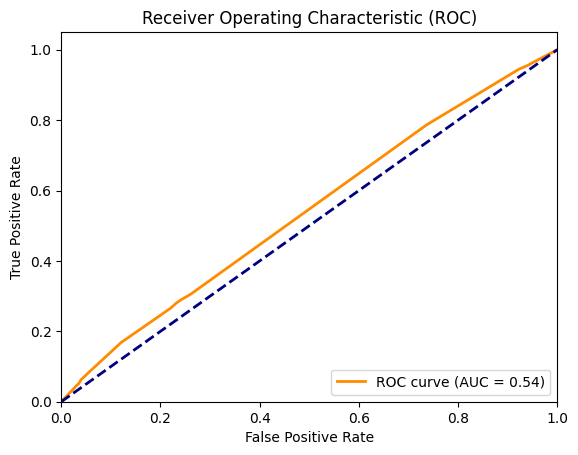

In [15]:
# Celda 5: Ejecución principal
# Cargar credenciales
with open("credentials.yaml", "r") as f:
    config = yaml.safe_load(f)

# Definir bucket
bucket = "aplicaciones-cd-2-" + config['iexe']['matricula']

# Cargar modelo y datos
model = load_model(bucket, "selected-model/selected_model.pkl")
test_data = load_test(bucket, "dataset/test/test_dataset.pkl")

# Generar y guardar predicciones
predictions = get_predictions(model, test_data)
save_predictions(predictions, bucket, str(date.today()))

# Generar y guardar ROC y métricas
true_labels = test_data.iloc[:, -1]
generate_roc(predictions, true_labels, bucket)
generate_metrics(predictions, true_labels, bucket)

# Cargar threshold y generar etiquetas finales
threshold_data = load_model(bucket, "best_model/threshold.pkl")
threshold = threshold_data[1]  # Asumiendo que el threshold está en la segunda posición de la tupla

# Generar y guardar etiquetas
labels = (predictions >= threshold).astype(int)
session = boto3.Session(
    aws_access_key_id=config['s3']['aws_access_key_id'],
    aws_secret_access_key=config['s3']['aws_secret_access_key'],
    aws_session_token=config['s3']['aws_session_token']
)

s3 = session.resource('s3')
pickle_data = pickle.dumps(labels)
s3.Object(bucket, 'results/predictions_label.pkl').put(Body=pickle_data)

print("¡Proceso completado exitosamente!")